In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

In [4]:
# Load your datasets
radiomic_data = pd.read_csv('/home/enriq115/dev/research/radiomic_features.csv')
name_mapping = pd.read_csv('/home/enriq115/dev/research/name_mapping.csv')

# Cleaned data
radiomic_data['Subject_ID'] = radiomic_data['Image'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[:3]))
radiomic_data.drop(['Mask', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Versions_PyRadiomics','diagnostics_Versions_Numpy','diagnostics_Versions_SimpleITK','diagnostics_Versions_PyWavelet','diagnostics_Versions_Python','diagnostics_Configuration_Settings','diagnostics_Configuration_EnabledImageTypes','diagnostics_Image-original_Hash','diagnostics_Image-original_Dimensionality','diagnostics_Image-original_Spacing','diagnostics_Image-original_Size', 'diagnostics_Image-original_Minimum'], axis=1, inplace=True)


In [5]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],      # Number of boosting stages
    'learning_rate': [0.2],              # Shrinkage rate
    'max_depth': [3, 7],                 # Maximum depth of the individual estimators
    'min_samples_split': [2, 5],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4],          # Minimum number of samples required in a leaf node
    'subsample': [ 0.8],                 # Fraction of samples used for fitting individual base learners
}

param_grid_svc = {
    'C': [0.1, 1, 10, 100,1000],              # Regularization parameter
    'kernel': [ 'rbf'],                       # Kernel type
    'gamma': [ 0.1, 1,0.01, 0.001, 0.0001],   # Kernel coefficient (for 'rbf', 'poly')
    'class_weight': [ 'balanced'],            # Handle class imbalance
}
param_grid_dt = {
    'criterion': ['gini', 'entropy'],               # Split criteria
    'splitter': [ 'best', 'random'],               # Splitting strategy
    'max_features': [None],                   # Features to consider at each split
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#uncomment model you want to use when predicting
labels = ['LGG', 'HGG']
#search = svm.SVC(C=1000, class_weight='balanced', gamma=0.001)
#search = DecisionTreeClassifier(max_depth=30, splitter='random', random_state=42)
search = GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.8)

#search = RandomizedSearchCV( estimator =clf, n_iter=10, param_distributions=param_grid_dt, scoring='f1', cv =5, verbose=1, n_jobs=-1, random_state=42 )

In [6]:
##For running normal data
namemapping_2020_df = name_mapping[['Grade', 'BraTS_2020_subject_ID']].rename(columns={'BraTS_2020_subject_ID': 'Subject_ID'})

# Merge datasets on the subject ID
merged_data = pd.merge(
    radiomic_data, namemapping_2020_df, 
    left_on='Subject_ID', right_on='Subject_ID', how='inner'
)

#Split data
X = merged_data.select_dtypes(include=['float64', 'int64'])  # Keep only numeric columns
y = merged_data['Grade']
y = y.map({'HGG': 1, 'LGG': 0})
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) # 70% training and 30% test

#Apply Scaling to training data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#OverSampling functions
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
X_smote, y_smote = smote.fit_resample(X_train, y_train) #Oversample data that has not bee scaled


In [7]:
#RUN THIS CODE ONLY AFTER RUNNING PREVIOUS CELL

#Normal data set ---------------------------------------
search.fit(X_train, y_train)

y_pred = search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

conf_matrix_df_train = pd.DataFrame(cm, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])

norm_accuracy = accuracy_score(y_test, y_pred)
norm_f1 =  f1_score(y_test, y_pred)

print("\n\nPredicting on Test Data")
print("\nAccuracy: ", norm_accuracy, " F1: ", norm_f1)
print("Confusion Matrix:\n", conf_matrix_df_train)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

#Normal while predicting on training data ---------------------------------------
search.fit(X_train, y_train)

y_pred = search.predict(X_train)
cm = confusion_matrix(y_train, y_pred)

conf_matrix_df_train = pd.DataFrame(cm, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])

train_norm_accuracy = accuracy_score(y_train, y_pred)
train_norm_f1 =  f1_score(y_train, y_pred)




print("\n\nPredicting on Training Data")
print("\nAccuracy: ", train_norm_accuracy, " F1: ", train_norm_f1)
print("Confusion Matrix:\n", conf_matrix_df_train)
print("\nClassification Report:\n", classification_report(y_train, y_pred, zero_division=1))

#Normal data set with smote ---------------------------------------
search.fit(X_smote, y_smote)

y_pred = search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

conf_matrix_df_train = pd.DataFrame(cm, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])

smote_norm_accuracy = accuracy_score(y_test, y_pred)
smote_norm_f1 =  f1_score(y_test, y_pred)


print("\n\nPredicting on Testing Data with only SMOTE")
print("\nAccuracy: ", smote_norm_accuracy, " F1: ", smote_norm_f1)
print("Confusion Matrix:\n", conf_matrix_df_train)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

#Normal data set with standard scaler ---------------------------------------
search.fit(X_train_scaled, y_train)

y_pred = search.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

conf_matrix_df_train = pd.DataFrame(cm, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])

scaled_norm_accuracy = accuracy_score(y_test, y_pred)
scaled_norm_f1 =  f1_score(y_test, y_pred)


print("\n\nPredicting on Testing Data with only Standard Scaler")
print("\nAccuracy: ", scaled_norm_accuracy, " F1: ", scaled_norm_f1)
print("Confusion Matrix:\n", conf_matrix_df_train)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

#Normal data set with smote and standard scaler ---------------------------------------
search.fit(X_res, y_res)

y_pred = search.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

conf_matrix_df_train = pd.DataFrame(cm, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])

new_norm_accuracy = accuracy_score(y_test, y_pred)
new_norm_f1 =  f1_score(y_test, y_pred)

print("\n\nPredicting on Testing Data with both SMOTE and MinMax Scaler")
print("\nAccuracy: ", new_norm_accuracy, " F1: ", new_norm_f1)
print("\nConfusion Matrix:\n", conf_matrix_df_train)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))






Predicting on Test Data

Accuracy:  0.9831081081081081  F1:  0.9893842887473461
Confusion Matrix:
             Predicted LGG  Predicted HGG
Actual LGG             58              5
Actual HGG              0            233

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        63
           1       0.98      1.00      0.99       233

    accuracy                           0.98       296
   macro avg       0.99      0.96      0.97       296
weighted avg       0.98      0.98      0.98       296



Predicting on Training Data

Accuracy:  1.0  F1:  1.0
Confusion Matrix:
             Predicted LGG  Predicted HGG
Actual LGG            241              0
Actual HGG              0            939

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       939

    accuracy                         

In [8]:
#This cell is for concatenationg. If you want to predict without concatenation use two previous cells

namemapping_2020_df = name_mapping[['Grade', 'BraTS_2020_subject_ID']].rename(columns={'BraTS_2020_subject_ID': 'Subject_ID'})

# Merge datasets on the subject ID
merged_data = pd.merge(
    radiomic_data, namemapping_2020_df, 
    left_on='Subject_ID', right_on='Subject_ID', how='inner'
)

concat = merged_data.groupby(['Subject_ID', 'Grade']).apply(
     lambda x: pd.Series(np.concatenate([x[col].values for col in x.columns if col not in ['Subject_ID', 'Grade', 'Image']]))
,include_groups=False).reset_index()




# Rename columns for readability, if needed
concat.columns = ['Subject_ID', 'Grade'] + [f'Feature_{i+1}' for i in range(concat.shape[1] - 2)]

#Split data
X = concat.select_dtypes(include=['float64', 'int64'])  # Keep only numeric columns
y = concat['Grade']
y = y.map({'HGG': 1, 'LGG': 0})
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=103) # 70% training and 30% test

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#OverSampling functions
smote = SMOTE(random_state=42)
X_train_processed, y_train_processed = smote.fit_resample(X_train_scaled, y_train)



In [9]:
#RUN THIS CODE ONLY AFTER RUNNING PREVIOUS CELL

#Concatted data ----------------------------------------------------
search.fit(X_train, y_train)

y_pred = search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

conf_matrix_df_train = pd.DataFrame(cm, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])

concat_accuracy = accuracy_score(y_test, y_pred)
concat_f1 =  f1_score(y_test, y_pred)

print("\n\nPredicting on Testing Data after Concatenating")
print("\nAccuracy: ", concat_accuracy, " F1: ", concat_f1 )
print("Confusion Matrix:\n", conf_matrix_df_train)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))


#Concatted Data with smote and standard scaler -------------------------------------
search.fit(X_train_processed, y_train_processed)
y_pred = search.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)


#Create confusion matrix
conf_matrix_df = pd.DataFrame(cm, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])


concat_new_f1 = f1_score(y_test, y_pred)
concat_new_accuracy = accuracy_score(y_test, y_pred)
#Print results
# print("Best Parameters: ", search.best_params_)
# print("Best model: ", search.best_estimator_)

print("\nPredicting on Testing Data after Concatenating and using SMOTE/Scaler")
print("\nAccuracy: ", concat_new_accuracy , " F1: ", concat_new_f1)
print("Confusion Matrix:\n", conf_matrix_df)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))




Predicting on Testing Data after Concatenating

Accuracy:  0.8513513513513513  F1:  0.8990825688073395
Confusion Matrix:
             Predicted LGG  Predicted HGG
Actual LGG             14              5
Actual HGG              6             49

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72        19
           1       0.91      0.89      0.90        55

    accuracy                           0.85        74
   macro avg       0.80      0.81      0.81        74
weighted avg       0.85      0.85      0.85        74


Predicting on Testing Data after Concatenating and using SMOTE/Scaler

Accuracy:  0.918918918918919  F1:  0.9444444444444444
Confusion Matrix:
             Predicted LGG  Predicted HGG
Actual LGG             17              2
Actual HGG              4             51

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        19

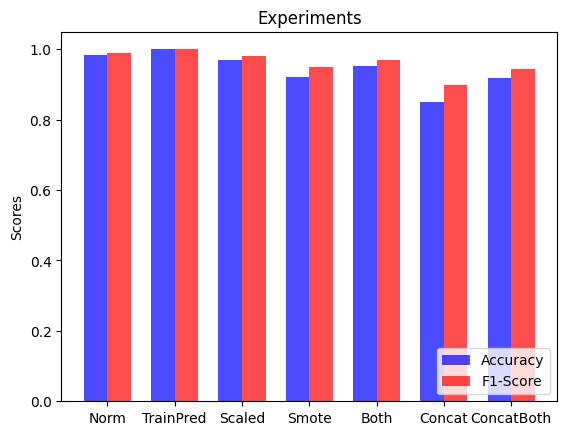

In [11]:
#Cell for plotting graphs with different categories

##### FOR ALL EXPERIMENTS #################
categories = ['Norm', 'TrainPred', 'Scaled','Smote', 'Both', 'Concat', 'ConcatBoth']
accuracy_scores = [norm_accuracy, train_norm_accuracy, scaled_norm_accuracy, smote_norm_accuracy, new_norm_accuracy, concat_accuracy, concat_new_accuracy]
f1_scores = [norm_f1, train_norm_f1, scaled_norm_f1, smote_norm_f1, new_norm_f1, concat_f1, concat_new_f1]

#####FOR OVERSAMPLING#################

# categories = ['Without Smote', 'With Smote']
# accuracy_scores = [norm_accuracy, smote_norm_accuracy]
# f1_scores = [norm_f1, smote_norm_f1]

#####FOR Standard Scaler#################

# categories = ['Without Scaling', 'With Scaling']
# accuracy_scores = [norm_accuracy, scaled_norm_accuracy]
# f1_scores = [norm_f1, scaled_norm_f1]

#####For comparison of predictions on training data and testing data #################

# categories = ['Predicting on Test Data', 'Predicting on Training Data']
# accuracy_scores = [norm_accuracy, train_norm_accuracy]
# f1_scores = [norm_f1, train_norm_f1]

#####For concat #################

# categories = ['Normal', 'Concatenation', 'Concat with SMOTE/Scaling']
# accuracy_scores = [norm_accuracy, concat_accuracy, concat_new_accuracy]
# f1_scores = [norm_f1, concat_f1, concat_new_f1]

# Grouped bar chart parameters
x = range(len(categories))  # x-coordinates for the groups
bar_width = 0.35  # Width of each bar

fig, ax = plt.subplots()
bar1 = ax.bar([i - bar_width/2 for i in x], accuracy_scores, bar_width, label='Accuracy', color='blue', alpha=0.7)
bar2 = ax.bar([i + bar_width/2 for i in x], f1_scores, bar_width, label='F1-Score', color='red', alpha=0.7)

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Experiments')
ax.set_xticks(x)
ax.set_xticklabels(categories)  # Use metric labels for x-axis
ax.legend(loc='lower right')
